Rad229_EPI_Ghosting demonstrates ghosting artifacts in EPI.

These questions can be used to further explore the code and concepts.

1. Examine a range of sys.dB0_ppm to explain why ghosting artifacts in EPI remain challenging to eliminate.

1. Why are EPI ghosting artifacts less of a problem at lower B0?

1.  What is the impact of shorter echo spacing on EPI ghosting?

1. The EPI ghosting artifacts for constant B0-field shifts always show a ghost at FOV/2. Why?

1. [Advanced] Compare the EPI ghosting artifacts between constant and linear field shifts. Explain the orgins of the differences (this is not obvious!). See Bernstein Chp. 16.1.

DBE@STANFORD.EDU (May 2021) for Rad229

DBE@STANFORD.EDU (May 2025) for Rad229 Python Version


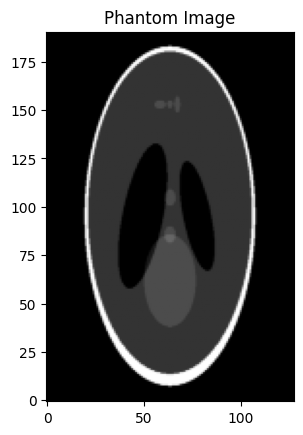

In [10]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
#! git clone https://github.com/mribri999/MRSignalsSeqs.git &> /dev/null # Clones the RAD229 repo
#import sys, os
#python_code_path = '/content/MRSignalsSeqs/Python/'
#sys.path.append(python_code_path) # To load the mrsigpy functions
#os.chdir(python_code_path) # Change directory to Python folder

import numpy as np
from Rad229_MRI_Phantom import rad229_mri_phantom
import matplotlib.pyplot as plt
from scipy.ndimage import shift

# System parameters
sys = {}
sys['B0'] = 3.0  # Magnetic field strength in Tesla
sys['gamma_bar'] = 42.57e6  # 1H gyromagnetic ratio in [Hz/T]

sys['dB0_ppm'] = 100.5e-6  # sys.B0 shift [ppm]
sys['dB0'] = sys['dB0_ppm'] * sys['B0']  # sys.B0 shift [T]
sys['f0'] = sys['gamma_bar'] * sys['dB0']  # Frequency offset [Hz]

# Acquisition parameters
acq = {}
acq['Nx'] = 128
acq['Ny'] = 191
acq['ESP'] = 100e-6  # Echo spacing [s]

# Generate a phantom object
phantom, mask = rad229_mri_phantom(acq)  # Make a Shepp-Logan phantom
phantom = np.array(phantom, dtype=complex)  # Cast phantom as complex

# Assuming acq is a dictionary and P is a 2D NumPy array
#pad_width = int(acq['Nx'] / 4)
#phantom = np.pad(phantom, pad_width=((pad_width, pad_width), (pad_width, pad_width)), mode='constant', constant_values=0)

# Update matrix size after padding
acq['Ny'] = phantom.shape[0]  # Rows
acq['Nx'] = phantom.shape[1]  # Columns

# Make figure of the phantom
plt.figure
plt.imshow(np.abs(phantom), cmap='gray', origin='lower');
plt.title('Phantom Image');

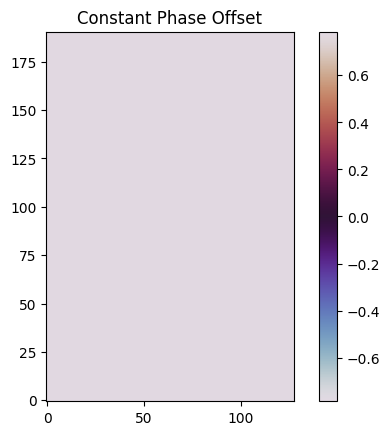

In [11]:
# Generate a spatially independent and constant phase from a B0 offset
phase_off = 2 * np.pi * sys['f0'] * acq['ESP'] * np.ones_like(phantom, dtype=float) # Phase offset [rad]

# Create a constant phase field with the same shape as P
#sys['phs'] = sys['dphs'] * np.ones_like(phantom)  # Phase offset field [rad]

# Plot the constant phase offset
plt.figure()
plt.imshow(phase_off, cmap='twilight', origin='lower')
plt.title('Constant Phase Offset')
plt.colorbar()
plt.clim(-np.pi/4, np.pi/4)
plt.show()

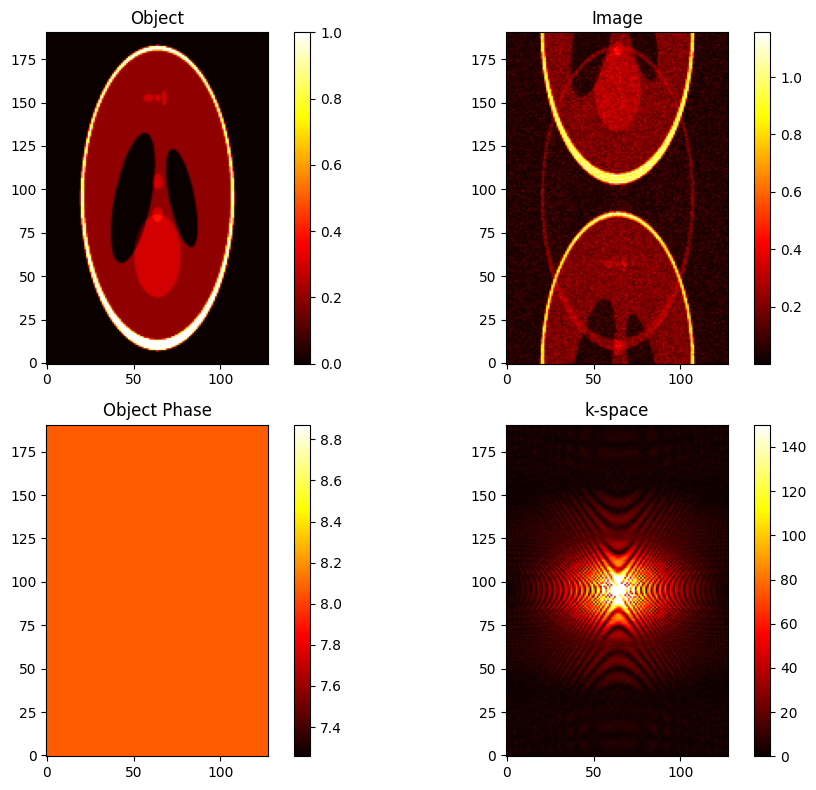

In [12]:
# Even echoes see +phs; odd echoes see -phs
obj_pos_phase = phantom * np.exp(+1j * phase_off)
obj_neg_phase = phantom * np.exp(-1j * phase_off)

# Simulate EPI readout: even and odd k-space lines
kspc_odd = np.fft.fftshift(np.fft.fft2(obj_pos_phase))
kspc_even = np.fft.fftshift(np.fft.fft2(obj_neg_phase))

# Interleave odd and even lines
kspc = np.zeros_like(kspc_even, dtype=complex)
kspc[0::2, :] = kspc_odd[0::2, :]
kspc[1::2, :] = kspc_even[1::2, :]

# Reconstruct the image and add some complex noise
IM = np.fft.ifft2(np.fft.fftshift(kspc))
IM += (np.random.randn(*IM.shape) + 1j * np.random.randn(*IM.shape)) / 25

plt.figure(figsize=(10, 8))
plt.colormaps()  # Just ensures colormaps are available
plt.set_cmap('hot')  # Set colormap

# Subplot 1: Object
plt.subplot(2, 2, 1)
plt.imshow(np.abs(phantom), aspect='equal', origin='lower')
plt.title('Object')
plt.colorbar()

# Subplot 2: Image
plt.subplot(2, 2, 2)
plt.imshow(np.abs(IM), aspect='equal', origin='lower')
plt.title('Image')
plt.colorbar()

# Subplot 3: Object Phase
plt.subplot(2, 2, 3)
plt.imshow(phase_off, aspect='equal', origin='lower')
plt.title('Object Phase')
plt.colorbar()

# Subplot 4: k-space
plt.subplot(2, 2, 4)
plt.imshow(np.abs(kspc), aspect='equal', origin='lower')
plt.title('k-space')
plt.colorbar()
plt.clim(0, 150)

plt.tight_layout()
plt.show()

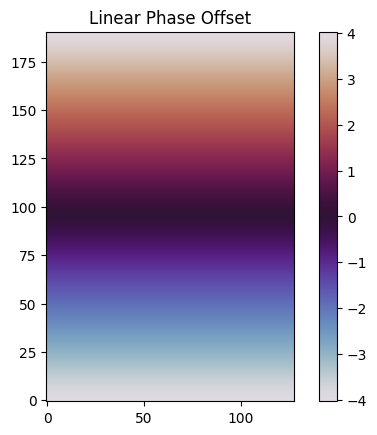

In [15]:
# Create a linear phase distribution

# Create a LINEAR off-resonance frequency array (phase encode direction)
phase_off = 2 * np.pi * sys['f0'] * acq['ESP']
off_x = np.linspace( 1 , 1 , acq['Nx'] );  # Arbitrary off-resonance frequency [Hz]
off_y = np.linspace( -phase_off / 2 , phase_off / 2 , acq['Ny'] );  # Arbitrary off-resonance frequency [Hz]

# Create the off-resonance frequency grid across the FOV
phase_off = np.outer(off_y, off_x)  # Using np.outer to get the outer product

# Plot the constant phase offset
plt.figure()
plt.imshow(phase_off, cmap='twilight', aspect='equal', origin='lower')
plt.title('Linear Phase Offset')
plt.colorbar()
#plt.clim(-np.pi/4, np.pi/4)
plt.show()

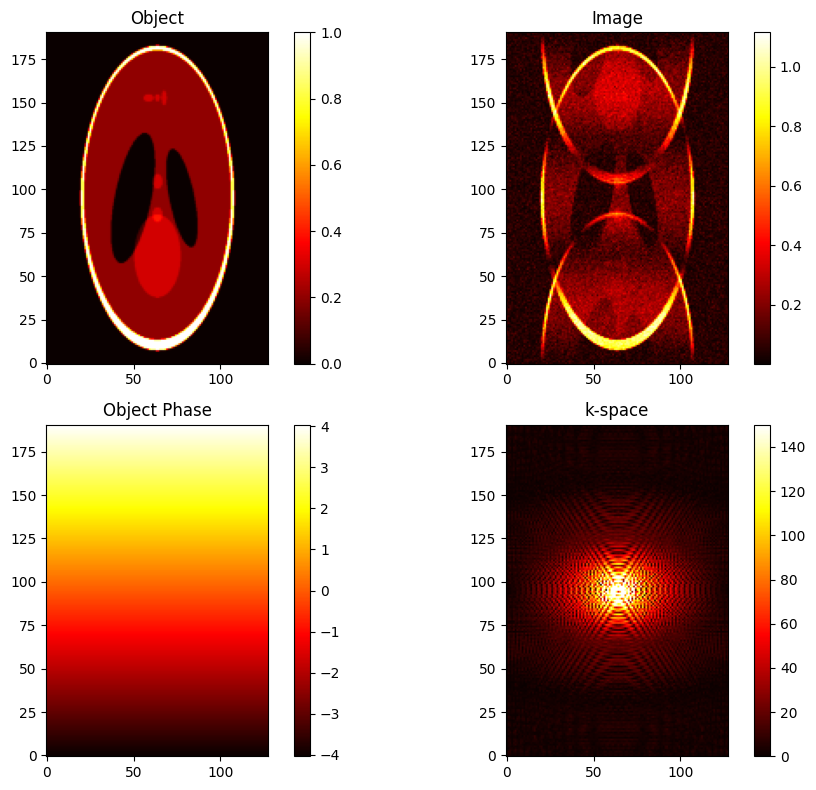

In [16]:
# Even echoes see +phs; odd echoes see -phs
obj_pos_phase = phantom * np.exp(+1j * phase_off)
obj_neg_phase = phantom * np.exp(-1j * phase_off)

# Simulate EPI readout: even and odd k-space lines
kspc_odd = np.fft.fftshift(np.fft.fft2(obj_pos_phase))
kspc_even = np.fft.fftshift(np.fft.fft2(obj_neg_phase))

# Interleave odd and even lines
kspc = np.zeros_like(kspc_even, dtype=complex)
kspc[0::2, :] = kspc_odd[0::2, :]
kspc[1::2, :] = kspc_even[1::2, :]

# Reconstruct the image and add some complex noise
IM = np.fft.ifft2(np.fft.fftshift(kspc))
IM += (np.random.randn(*IM.shape) + 1j * np.random.randn(*IM.shape)) / 25

plt.figure(figsize=(10, 8))
plt.colormaps()  # Just ensures colormaps are available
plt.set_cmap('hot')  # Set colormap

# Subplot 1: Object
plt.subplot(2, 2, 1)
plt.imshow(np.abs(phantom), aspect='equal', origin='lower')
plt.title('Object')
plt.colorbar()

# Subplot 2: Image
plt.subplot(2, 2, 2)
plt.imshow(np.abs(IM), aspect='equal', origin='lower')
plt.title('Image')
plt.colorbar()

# Subplot 3: Object Phase
plt.subplot(2, 2, 3)
plt.imshow(phase_off, aspect='equal', origin='lower')
plt.title('Object Phase')
plt.colorbar()

# Subplot 4: k-space
plt.subplot(2, 2, 4)
plt.imshow(np.abs(kspc), aspect='equal', origin='lower')
plt.title('k-space')
plt.colorbar()
plt.clim(0, 150)

plt.tight_layout()
plt.show()